In [65]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA 
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [66]:
# Ignore warnings produced from slicing data
import warnings
warnings.filterwarnings("ignore")

In [67]:
# Read in data
df = pd.read_csv('C:\\Users\halln\Desktop\THINKFUL\Datasets\CO2_emission_prediction\emissions.csv')

# Convert to Datetime format
df['Date'] = df['YYYYMM'].apply(lambda x: pd.to_datetime(x, format='%Y%m',errors='coerce'))
# Remove NaT values
df['NaT'] = df['Date'].apply(lambda x: str(x))
df = df[df['NaT']!='NaT']
df = df.drop(columns='NaT')

# Remove entries that are 'Not Available'
df = df[df['Value']!='Not Available']
# Convert data to float 
df['Value'] = df['Value'].apply(lambda x: pd.to_numeric(x))

# Index data with dates
data = pd.DataFrame(index=df['Date'])
data['Value'] = list(df['Value'])
data['Description'] = list(df['Description'])

                                                        Value
Description                                                  
Total Energy Electric Power Sector CO2 Emissions    82352.676
Coal Electric Power Sector CO2 Emissions            65782.393
Natural Gas Electric Power Sector CO2 Emissions     11295.359
Petroleum Electric Power Sector CO2 Emissions        4982.993
Residual Fuel Oil Electric Power Sector CO2 Emi...   4239.312
Distillate Fuel, Including Kerosene-Type Jet Fu...    404.887
Petroleum Coke Electric Power Sector CO2 Emissions    338.785
Non-Biomass Waste Electric Power Sector CO2 Emi...    281.367
Geothermal Energy Electric Power Sector CO2 Emi...     10.563


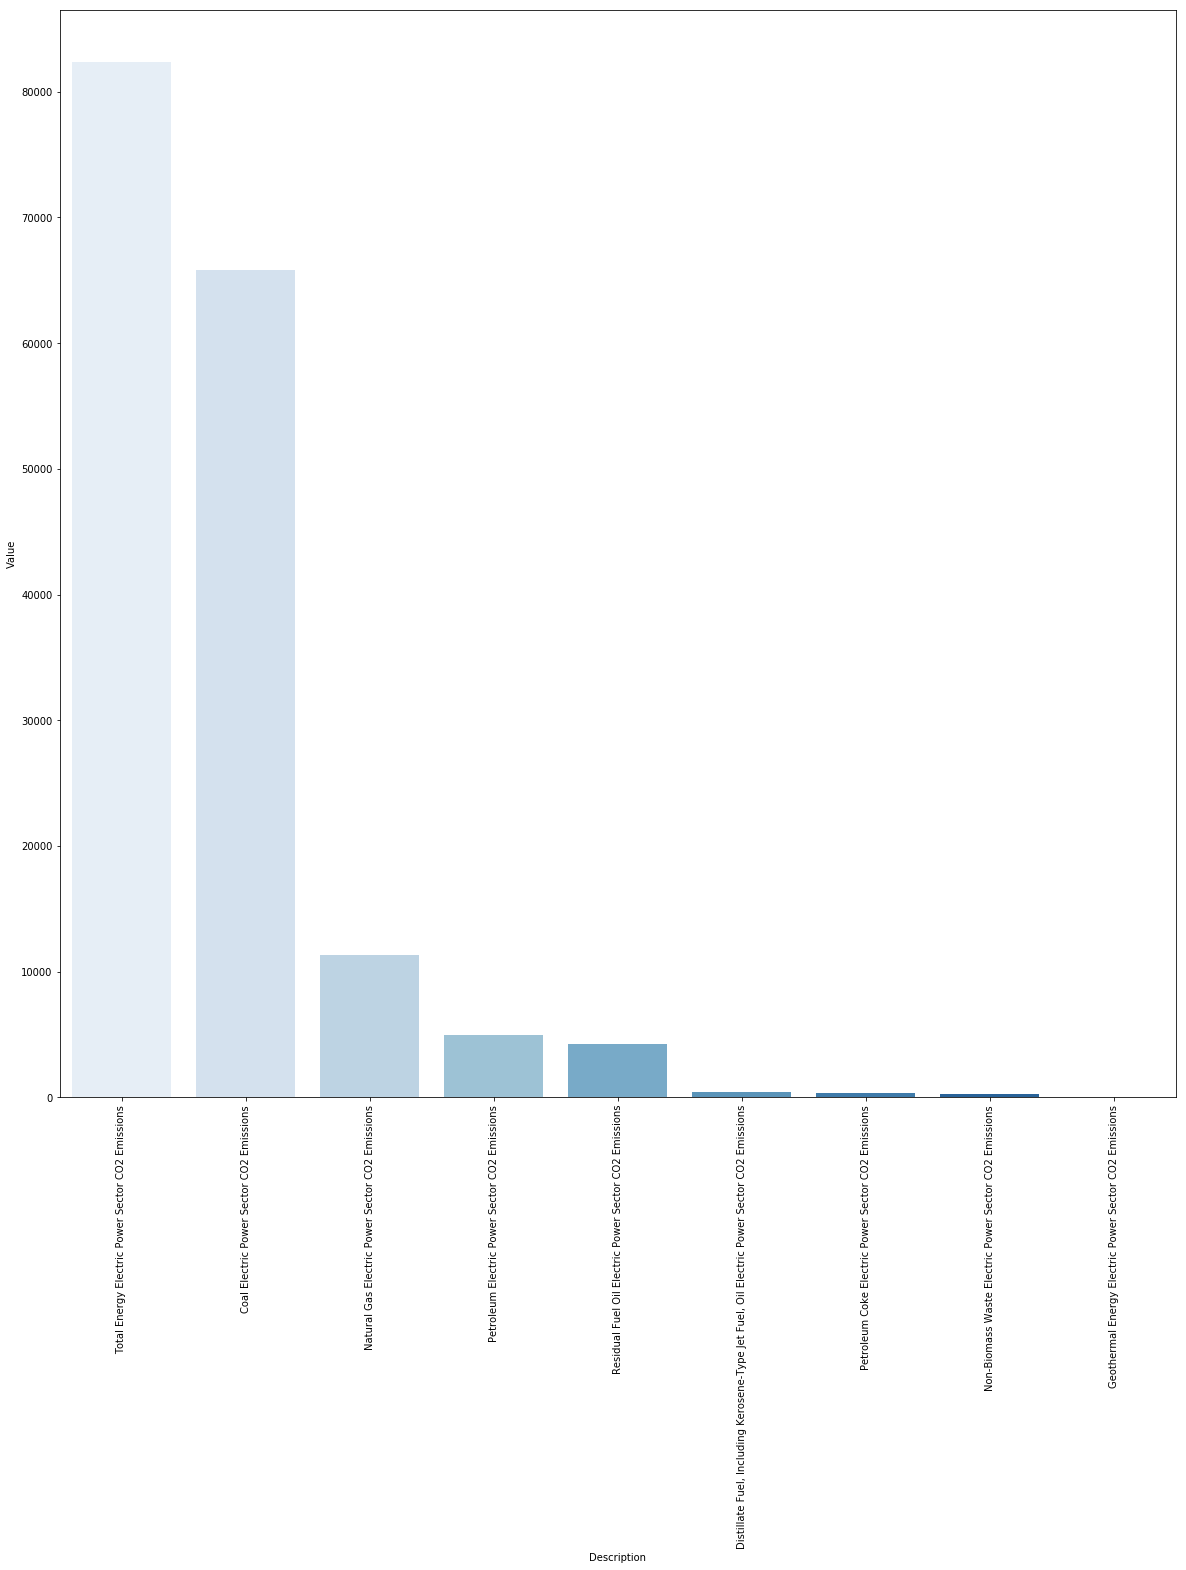

In [68]:
# Show biggest contributiors to CO2 output
sources = data.groupby('Description').sum()
bar = sources.sort_values(by='Value',ascending=False)
print(bar)

# Create barplot showing biggest contributors to CO2 output
plt.figure(figsize=(20,20))
sns.barplot(y='Value',x=bar.index,data=bar,palette='Blues')
plt.xticks(rotation='vertical')
plt.show()

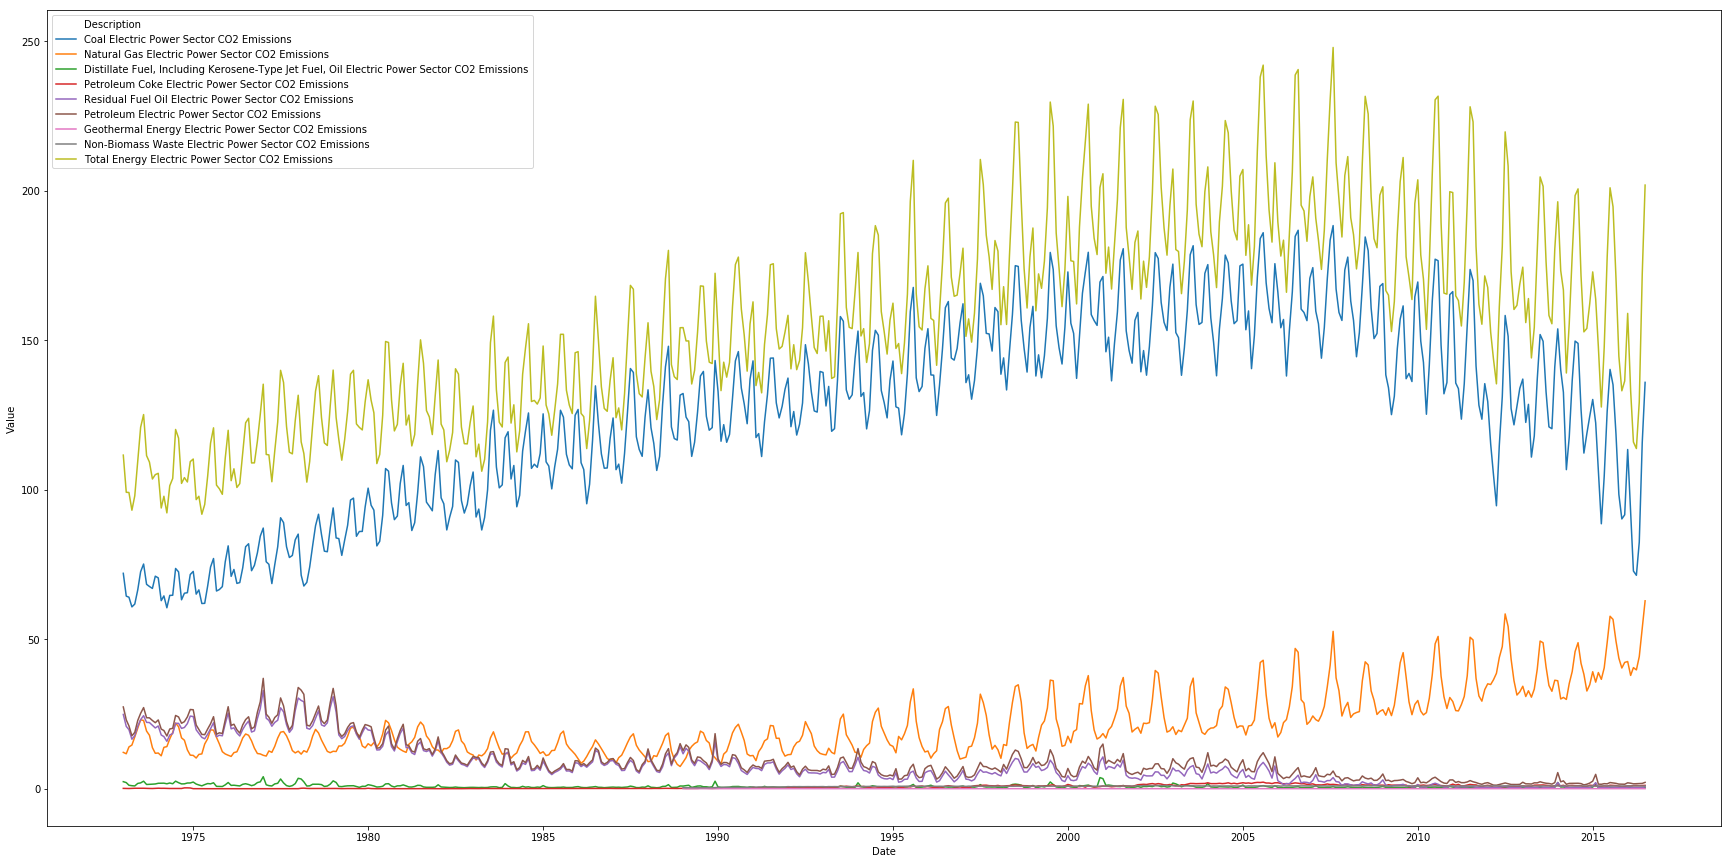

In [69]:
# Plot trend in CO2 output by source over time
plt.figure(figsize=(30,15))
sns.lineplot(data=data, x=data.index,y='Value',hue='Description')

In [70]:
# Collect top 5 contributors into seperate variables
te = data[data['Description']=='Total Energy Electric Power Sector CO2 Emissions']
ce = data[data['Description']=='Coal Electric Power Sector CO2 Emissions']
ng = data[data['Description']=='Natural Gas Electric Power Sector CO2 Emissions']
pe = data[data['Description']=='Petroleum Electric Power Sector CO2 Emissions']
rf = data[data['Description']=='Residual Fuel Oil Electric Power Sector CO2 Emissions']

In [71]:
def test_stationarity(timeseries):
    
    # Determing rolling statistics for timeseries
    rolmean = timeseries.rolling(center=False,window=12).mean()
    rolstd = timeseries.rolling(center=False,window=12).std()

    # Plot rolling statistics alongside data
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation of Time Series')
    plt.show(block=False)
    
    # Create ACF Plot of timeseries
    plot_acf(timeseries.dropna(inplace=False))
    plt.xlim(0,25)
    plt.title("ACF Plot")
    plt.show()
    
    # Create PACF Plot of timeseries
    x_pacf = pd.DataFrame(pacf(timeseries.dropna(inplace=False)))
    x_pacf.plot(kind='bar')
    plt.title("PACF Plot")
    plt.show()
    
    #Perform Dickey-Fuller test and print results
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    output = pd.Series(dftest[0:4], index=['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        output['Critical Value (%s)'%key] = value
    print(output)
    

# First well try modeling the total electric CO2 Output

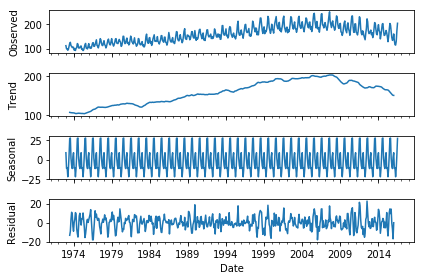

In [72]:
# Decompose data to show overall trend in data - data appears to be very seasonally dependent
decomp = seasonal_decompose(te.Value,model='additive')
decomp.plot()
plt.show()

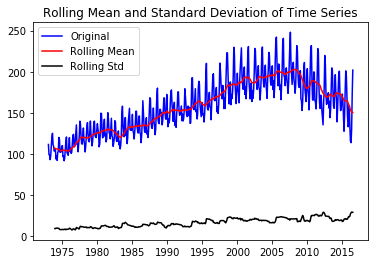

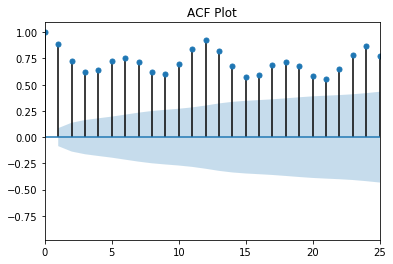

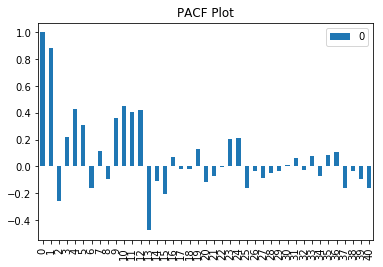

Results of Dickey-Fuller Test:
ADF Test Statistic              -1.809627
p-value                          0.375693
Number of Lags Used             14.000000
Number of Observations Used    508.000000
Critical Value (1%)             -3.443288
Critical Value (5%)             -2.867246
Critical Value (10%)            -2.569809
dtype: float64


In [73]:
# Test Stationarity of Total Electric CO2 Output
test_stationarity(te.Value)

In [74]:
# Lets try shifting the data in a number of different ways to make data stationary
te['Log_Difference'] = np.log(te.Value).diff()
te['Seasonal_Difference'] = te.Value - te.Value.shift(12)
te['Shift_1'] = te.Value - te.Value.shift(1)

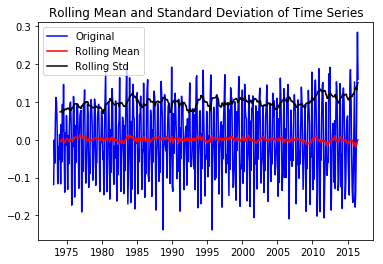

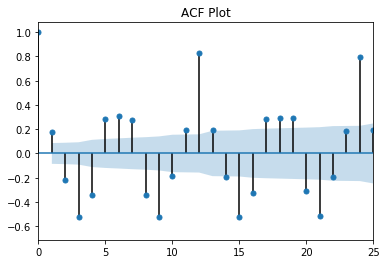

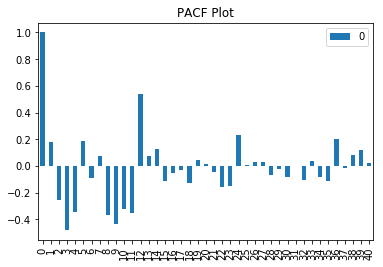

Results of Dickey-Fuller Test:
ADF Test Statistic            -6.487986e+00
p-value                        1.246987e-08
Number of Lags Used            1.300000e+01
Number of Observations Used    5.080000e+02
Critical Value (1%)           -3.443288e+00
Critical Value (5%)           -2.867246e+00
Critical Value (10%)          -2.569809e+00
dtype: float64


In [75]:
test_stationarity(te.Log_Difference.dropna(inplace=False))

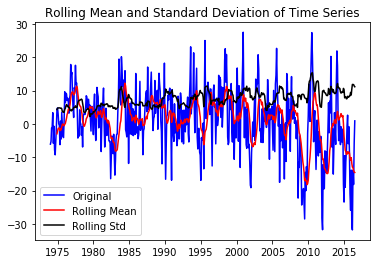

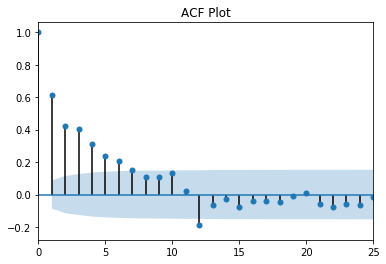

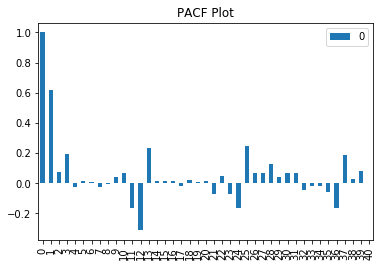

Results of Dickey-Fuller Test:
ADF Test Statistic              -5.495918
p-value                          0.000002
Number of Lags Used             12.000000
Number of Observations Used    498.000000
Critical Value (1%)             -3.443549
Critical Value (5%)             -2.867361
Critical Value (10%)            -2.569870
dtype: float64


In [76]:
test_stationarity(te.Seasonal_Difference.dropna(inplace=False))

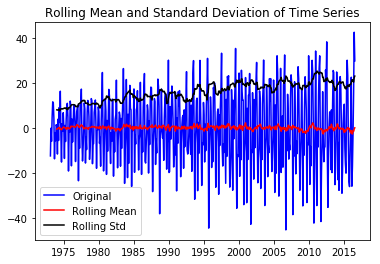

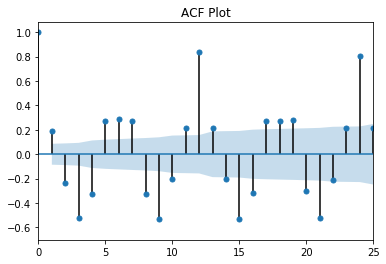

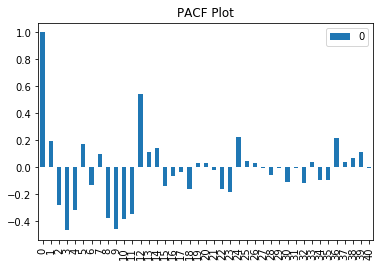

Results of Dickey-Fuller Test:
ADF Test Statistic            -6.610275e+00
p-value                        6.402884e-09
Number of Lags Used            1.300000e+01
Number of Observations Used    5.080000e+02
Critical Value (1%)           -3.443288e+00
Critical Value (5%)           -2.867246e+00
Critical Value (10%)          -2.569809e+00
dtype: float64


In [77]:
test_stationarity(te.Shift_1.dropna(inplace=False))

In [78]:
# Data definitely appears to be seasonally dependent but this doesent capture the full trend 
te['Seas_Log_Diff'] = np.log(te.Seasonal_Difference).diff()

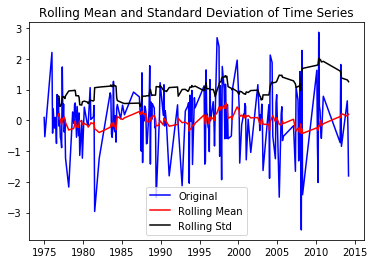

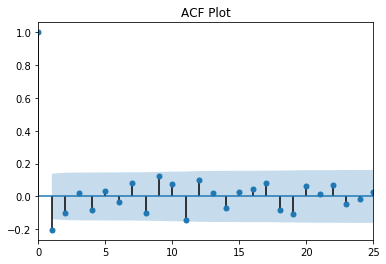

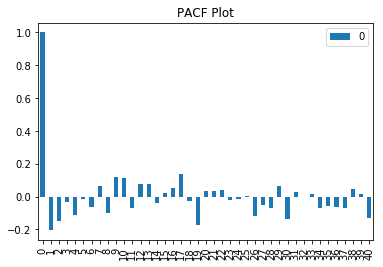

Results of Dickey-Fuller Test:
ADF Test Statistic            -1.256094e+01
p-value                        2.103280e-23
Number of Lags Used            1.000000e+00
Number of Observations Used    1.980000e+02
Critical Value (1%)           -3.463815e+00
Critical Value (5%)           -2.876251e+00
Critical Value (10%)          -2.574611e+00
dtype: float64


In [79]:
test_stationarity(te.Seas_Log_Diff.dropna(inplace=False))

In [80]:
# Split into test and training data for model - use last 5 years for validation? 

# Split off just total energy
te = data[data['Description']=='Total Energy Electric Power Sector CO2 Emissions']
# Shift Data
te['Seasonal_Difference'] = te.Value - te.Value.shift(12)
te['Seas_Log_Diff'] = np.log(te.Seasonal_Difference).diff()
# Split into training and test set
te_train = te[te.index < '2010-01-01']
te_test = te[te.index >= '2010-01-01']

In [81]:
# Define function to generate predictions for each arima order
def evaluate_arima(train, test, arima_order):
    # Populate history based on training set
    history = [x for x in train]
    # Create blank list of predictions to populate
    predictions = list()
    # Use rolling forward walk predictions.  Fit model using history,
    # adding each prediction to history to continue forecasting
    for i in range(len(test)):
        # Fit using history
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        # Get prediction
        y_pred = model_fit.forecast()[0]
        # Append prediction to prediction list to check accuracy 
        predictions.append(y_pred)
        # Append to history to continue to rolling forecast 
        history.append(y_pred)
    error = mean_squared_error(test, predictions)
    return error


# Define function to determine best arima specifications based on MSE
def arima_gridsearch(train, test, p_vals, d_vals, q_vals):
    # Create blank variables to store parameters in
    best_score = float('inf') 
    best_config = None
    for p in p_vals:
        for d in d_vals:
            for q in q_vals:
                arima_order = (p, d, q)
                # Evaluate arima model with each combination of specifications 
                # and append best results to list
                try:
                    mse = evaluate_arima(train, test, arima_order)
                    if mse < best_score:
                        best_score, best_config = mse, arima_order
                    print('ARIMA Parameters: {}   Resulting MSE:{}'.format(arima_order, mse))
                except (ValueError, np.linalg.LinAlgError): # ignore non converging errors
                    pass
    print('Best ARIMA config:', best_config)
    print('MSE:', best_score)

In [85]:
# Do Gridsearch to find best arima parameters for raw data
arima_gridsearch(te_train.Value.dropna(inplace=False),te_test.Value.dropna(inplace=False), range(5),range(5),range(3))

ARIMA Parameters: (0, 0, 0)   Resulting MSE:923.1188965168923
ARIMA Parameters: (0, 0, 1)   Resulting MSE:893.4768421403121
ARIMA Parameters: (0, 1, 0)   Resulting MSE:1817.454393223415
ARIMA Parameters: (0, 1, 1)   Resulting MSE:2280.7662881996616
ARIMA Parameters: (0, 1, 2)   Resulting MSE:2104.4163185948246
ARIMA Parameters: (0, 2, 0)   Resulting MSE:2714219.1283221478
ARIMA Parameters: (0, 2, 1)   Resulting MSE:1745.3196453149526
ARIMA Parameters: (0, 2, 2)   Resulting MSE:2448.6681511019133
ARIMA Parameters: (1, 0, 0)   Resulting MSE:727.0527522063767
ARIMA Parameters: (1, 0, 1)   Resulting MSE:763.4718293819994
ARIMA Parameters: (1, 0, 2)   Resulting MSE:920.969258032912
ARIMA Parameters: (1, 1, 0)   Resulting MSE:2198.5888945905713
ARIMA Parameters: (1, 1, 1)   Resulting MSE:2871.355982266053
ARIMA Parameters: (1, 1, 2)   Resulting MSE:2898.3498476005775
ARIMA Parameters: (1, 2, 0)   Resulting MSE:1435721.0615128975
ARIMA Parameters: (2, 0, 0)   Resulting MSE:772.2945834212047
A

In [ ]:
te_test.columns

In [83]:
# Do Gridsesarch to find best ARIMA parameters for shifted data - Unsure if this is proper way to feed shifted data into model or not
arima_gridsearch(te_train.Seas_Log_Diff.dropna(inplace=False),te_test.Seas_Log_Diff.dropna(inplace=False),range(5),range(5),range(5))

ARIMA Parameters: (0, 0, 0)   Resulting MSE:1.6824867119849098
ARIMA Parameters: (0, 0, 1)   Resulting MSE:1.5902499079788368
ARIMA Parameters: (0, 0, 2)   Resulting MSE:1.669489385836042
ARIMA Parameters: (0, 0, 3)   Resulting MSE:1.670200718213633
ARIMA Parameters: (0, 0, 4)   Resulting MSE:1.626923907805081
ARIMA Parameters: (0, 1, 0)   Resulting MSE:8.444571802908468
ARIMA Parameters: (0, 1, 1)   Resulting MSE:1.686684434413585
ARIMA Parameters: (0, 2, 0)   Resulting MSE:2117.7975499811405
ARIMA Parameters: (0, 2, 1)   Resulting MSE:9.988211980387257
ARIMA Parameters: (1, 0, 0)   Resulting MSE:1.600080564157193
ARIMA Parameters: (1, 0, 1)   Resulting MSE:1.619961007724417
ARIMA Parameters: (1, 0, 2)   Resulting MSE:1.670833215567911
ARIMA Parameters: (1, 1, 0)   Resulting MSE:2.3937906462640783
ARIMA Parameters: (1, 2, 0)   Resulting MSE:29.50472921924147
ARIMA Parameters: (1, 2, 3)   Resulting MSE:2.738559875531088
ARIMA Parameters: (2, 0, 0)   Resulting MSE:1.7006568166801062
ARI

In [ ]:
# Function to plot predictions
def plot_predictions(title,train, test, p, d, q):
    arima_order = (p,d,q)
    history = [x for x in train]
# Blank list to store predictions in
    predictions = list()
# Run model for multiple sets of parameters and append results
    for i in range(len(test)):
# Fit using history
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
# Forcast predicted results
        y_pred = model_fit.forecast()[0]
# Append forecasts to list
        predictions.append(y_pred)
# Append to history to continue to rolling forecast 
        history.append(y_pred)
# Create plots
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, predictions, label='Predictions')
    plt.title('{}'.format(str(title)))
    plt.legend()

# Define function to plot residuals of model
def plot_model_residuals(title, train, p, d, q):
    model = ARIMA(train, order=(p,d,q))
    model_fit = model.fit()
    residuals = model_fit.resid
# Create line plot of residuals
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('{}'.format(str(title)))
    residuals.plot()
# Create Histogram of residuals
    plt.subplot(1,2,2)
    residuals.hist(bins=25)
    plt.title('{}'.format(str(title)))
    plt.show()

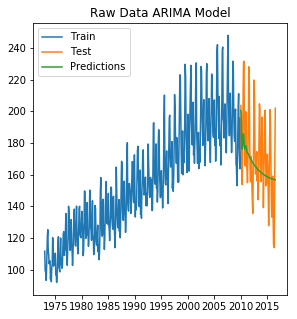

In [86]:
plot_predictions('Raw Data ARIMA Model',te_train.Value,te_test.Value,4,0,0)

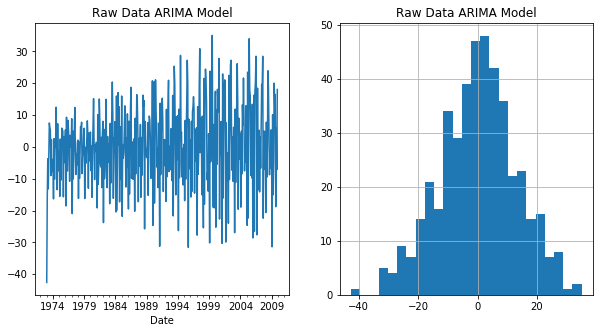

In [88]:
plot_model_residuals('Raw Data ARIMA Model',te_train.Value,4,0,0)

# Things to Add to Project
    -Add code to check normaility of residuals using QQ or PP plot
    -Add code in to forecast future results
    -Add code to apply these modeling techniques to other CO2 sources (eg. coal energy/ natural gas)

# QUESTIONS 
--------------------------------------------------------------------------------------------------------
- How do I go about applying shifted data to ARIMA model / using results from optimally shifted data? (eg. modeling with the seasonally shifted then log shited data)
    - Attempted below but I feel like I am going about it the wrong way
---------------------------------------------------------------------------------------------------------
- Saw somewhere that there is a seasonal arima model (SARIMA) is this a different type of model or is 
  it done by specifying a certain set of parameters within ARIMA model?
--------------------------------------------------------------------------------------------------------- 
- Shifting data causes gaps in data, which is what caused earlier plots we discussed to be blank
    - fixed this by adding dropna(inplace=False) whenever plotting with shifted variables
---------------------------------------------------------------------------------------------------------
- In predicted plot above data produced seemed to level off after steep decline - why would this be occurring?

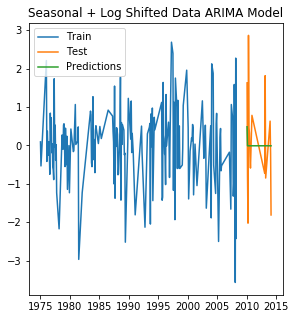

In [89]:
plot_predictions('Seasonal + Log Shifted Data ARIMA Model',te_train.Seas_Log_Diff.dropna(inplace=False),te_test.Seas_Log_Diff.dropna(inplace=False),0,0,1)

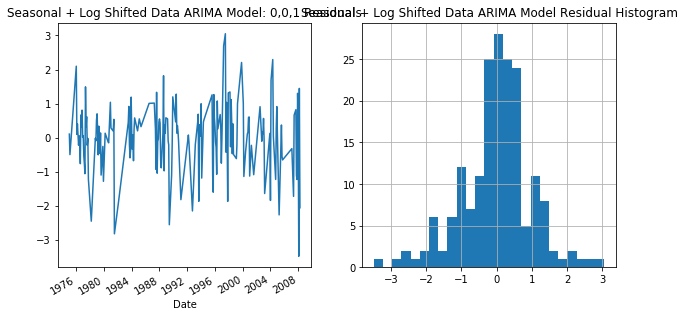

In [90]:
plot_residuals('Seasonal + Log Shifted Data ARIMA Model',te_train.Seas_Log_Diff.dropna(inplace=False),0,0,1)